In [9]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

## Utility functions

In [10]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [11]:
# def window_image(image, window_center, window_width):
#     img_min = window_center - window_width // 2
#     img_max = window_center + window_width // 2
#     window_image = image.copy()
#     window_image[window_image < img_min] = img_min
#     window_image[window_image > img_max] = img_max
    
#     return window_image

def remove_background(image):
    
#     intensity_background = image.min()
#     intensity_min = image_array[image_array > intensity_background].min()
    
#     #intensity_min = 1000
#     window_image = image.copy()
#     window_image[window_image < intensity_min] = intensity_min
#     print(window_image.min(), window_image.max())
#     return window_image
    
    img_min = 1000
    img_max = image.max()
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [12]:
def get_mask(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    
    return img2

In [13]:
def load_image(file_path):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    print(image.shape)
    return medical_image, image

def plot_images(images_list, save=False):
    
    image = images_list[0]
    window_image = images_list[1]
    brain_mask = images_list[2]
    brain_image = images_list[3]
    skull_image = images_list[4]
    
    plt.figure(figsize=(20, 10))
    plt.style.use('grayscale')

    plt.subplot(231)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(window_image)
    plt.title('Windowed image')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(brain_mask)
    plt.title('Brain mask')
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(brain_image)
    plt.title('brain image')
    plt.axis('off')
    
    plt.subplot(235)
    plt.imshow(skull_image)
    plt.title('Skull image')
    plt.axis('off')
    
#     if save:
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-original.png'), image)
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-hu_image.png'), hu_image)
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-brain_image.png'), brain_image)
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-bone_image.png'), bone_image)  

In [25]:
def process_image(image_array):
    window_image = remove_background(image_array)
    image_transformed = cv2.normalize(window_image, None, 0, 255, cv2.NORM_MINMAX) 
    brain_mask = get_mask(image_transformed)
    brain_image = brain_mask * image_transformed
    blurred = cv2.GaussianBlur(brain_image, (21, 21), 0) # selected with trail and error for outlier
    blurred_normalized = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
    thresh, skull_image = cv2.threshold(blurred_normalized, 0, 255, cv2.THRESH_OTSU)
    
    return [image_array, window_image, brain_mask, brain_image, skull_image]

In [26]:
medical_image, image_array = load_image('5.dcm')
images_list = process_image(image_array)

(512, 512)


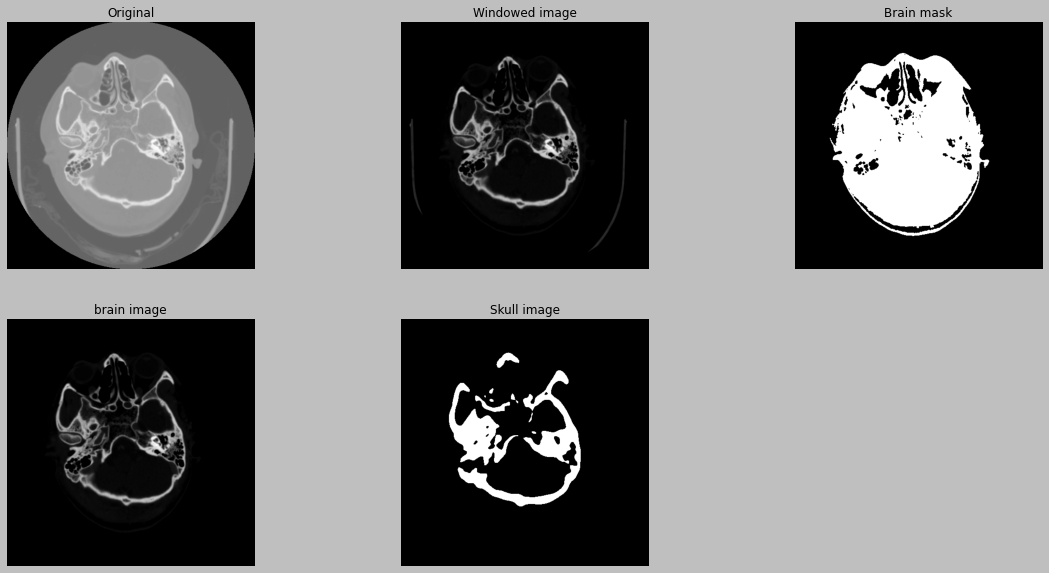

In [27]:
plot_images(images_list)